<a href="https://colab.research.google.com/github/StillWork/book7/blob/master/g_33_1_%EC%8B%9C%ED%80%80%EC%8A%A4%ED%8C%A8%ED%84%B4%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰 센서 데이터로 분류

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
!curl -L https://bit.ly/36LsyVs -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   153  100   153    0     0    138      0  0:00:01  0:00:01 --:--:--   138
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  1034    0  1034    0     0    424      0 --:--:--  0:00:02 --:--:--   424
100 10.5M  100 10.5M    0     0  3163k      0  0:00:03  0:00:03 --:--:-- 17.7M


In [ ]:
!unzip -o smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
   creating: __MACOSX/
  inflating: __MACOSX/._smartphone_human.txt  


In [ ]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [ ]:
!head -5 smartphone_human.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [ ]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)
df.dropna(axis=0, how='any', inplace=True)

In [ ]:
t = '3'
t = np.float(t)
type(t)

float

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [ ]:
df['user-id'].unique()

array([33, 17, 20, 29, 13, 15,  6, 27, 36, 18, 32, 35, 11, 16,  5, 10, 28,
       26, 14, 24, 12, 23,  4, 30, 34,  8, 31, 21,  3, 22,  1,  9, 25,  2,
        7, 19])

In [ ]:
df.shape

(1098203, 6)

In [ ]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

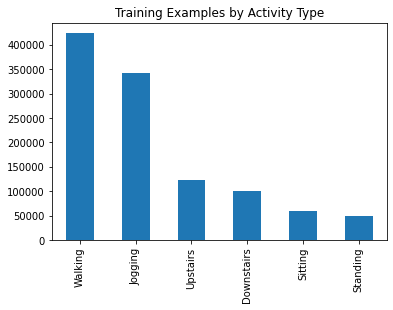

In [ ]:
# plt.figure(dpi=200)
df['activity'].value_counts().plot(kind='bar',
    title='Training Examples by Activity Type')
plt.show()

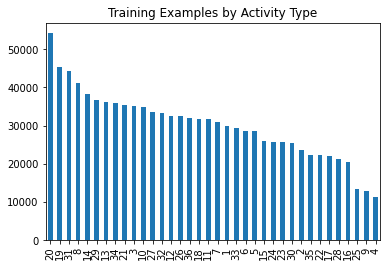

In [ ]:
df['user-id'].value_counts().plot(kind='bar',
    title='Training Examples by Activity Type')
plt.show()

In [ ]:
(df['timestamp']   >0).sum()

1085360

In [ ]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

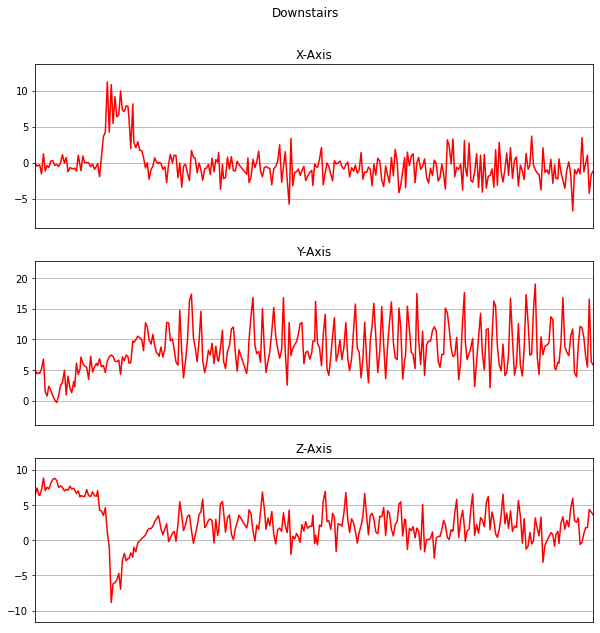

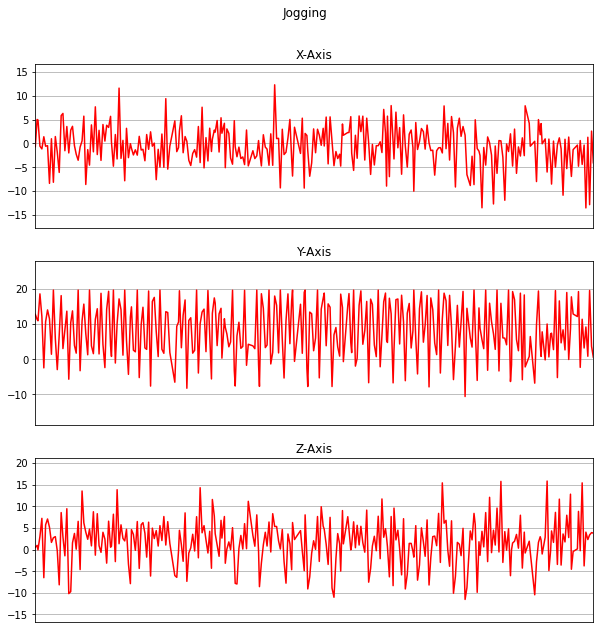

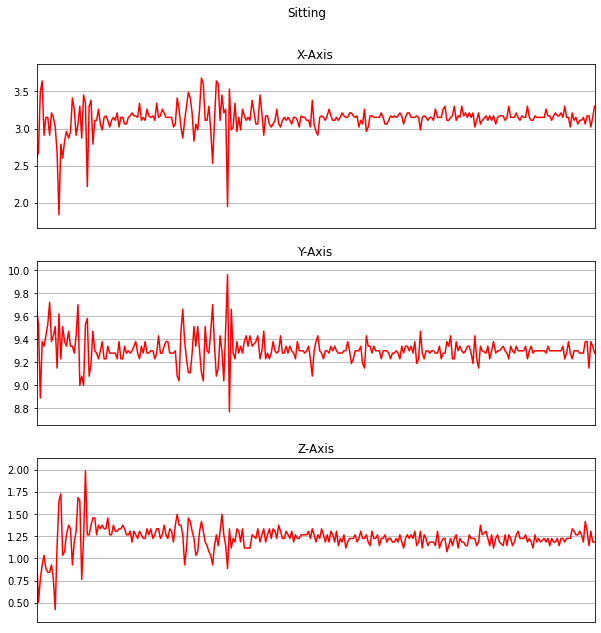

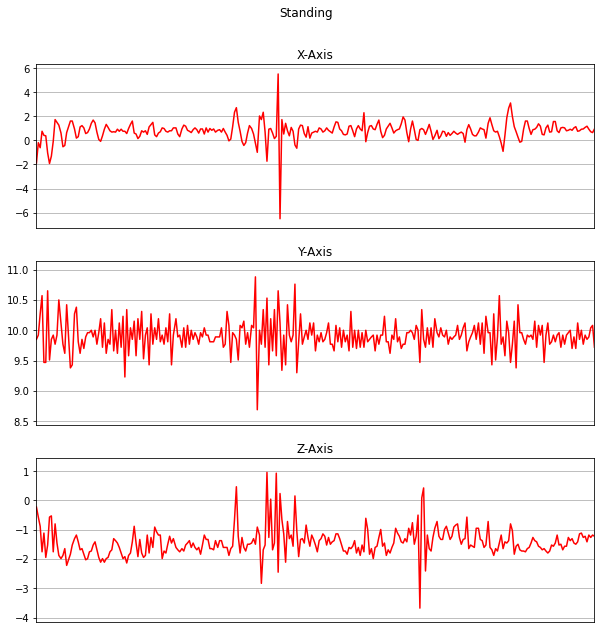

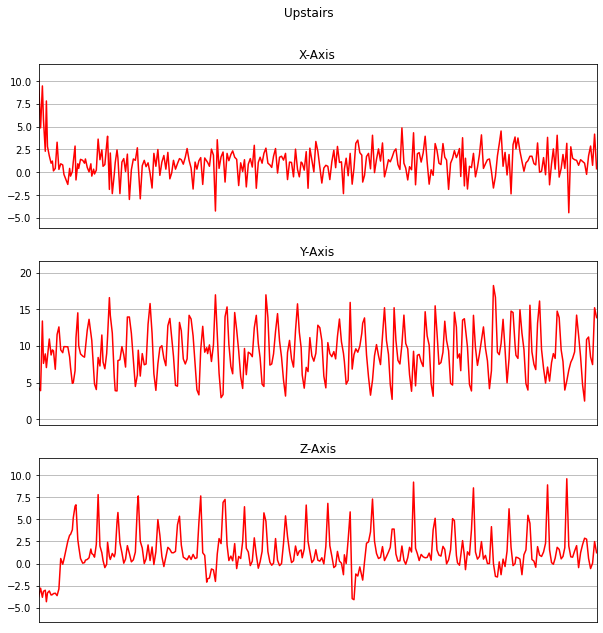

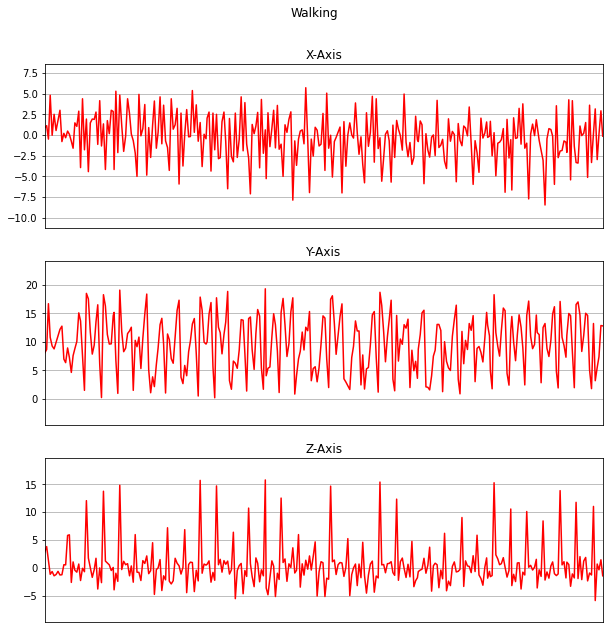

In [ ]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [ ]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [ ]:
df_train[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
8489,17,Walking,57869902574000,-0.014320,0.365785,-0.198062,5
8490,17,Walking,57870012316000,-0.097358,0.422373,-0.206607,5
8491,17,Walking,57870122301000,-0.130969,0.371848,-0.232242,5
8492,17,Walking,57870222246000,-0.075610,0.406205,-0.192366,5
8493,17,Walking,57870332292000,-0.075610,0.416310,-0.215152,5


In [ ]:
df['activity'].value_counts()

Walking       423905
Jogging       330330
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [ ]:
test = [3,3,3,3,3,3,3,3,3,3,2,2,3,3,4,4,4,4,4]
z = stats.mode(test)
z[0][0]

3

In [ ]:
z[1][0]

12

In [ ]:
z = stats.mode(df['act'][11000:11100])
z[0][0], z[1][0]

(5, 100)

In [ ]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [ ]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [ ]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


In [ ]:
df['user-id'] < 27

0          False
1          False
2          False
3          False
4          False
           ...  
1098199     True
1098200     True
1098201     True
1098202     True
1098203     True
Name: user-id, Length: 1085360, dtype: bool

In [ ]:
df_train = df[df['user-id'] < 27]
df_test = df[df['user-id'] >= 27]


(314459, 7)

In [ ]:
df_test.shape, df_train.shape

((314459, 7), (770901, 7))

In [ ]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
def split_seq (df, N):
#  N = 100
  X, y = [], []
  for i in range(0, len(df)-N+1, N):
      z = stats.mode(df['act'][i: i+N])
      action, count = z[0][0], z[1][0]
      if count == N:
          xs = df['x-axis'].values[i: i + N]
          ys = df['y-axis'].values[i: i + N]
          zs = df['z-axis'].values[i: i + N]
          X.append([xs, ys, zs])
          y.append(action)
  X = np.transpose(X, (0,2,1))
  y = np.array(y)
  return X, y

In [ ]:
X_train, y_train = split_seq(df_train, 100)

In [ ]:
X_test, y_test = split_seq(df_test, 100)

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

## 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.6361239288068556

# MLP

In [ ]:
y.shape

(10469, 6)

In [ ]:
model_m = Sequential()
# model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(100, activation='relu',input_shape=(N*3,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=10,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 5947 samples, validate on 1487 samples
Epoch 1/30
5947/5947 [==============================] - 3s 542us/step - loss: 0.0392 - accuracy: 0.9874 - val_loss: 2.4534 - val_accuracy: 0.6980
Epoch 2/30
5947/5947 [==============================] - 3s 513us/step - loss: 0.0227 - accuracy: 0.9943 - val_loss: 1.9770 - val_accuracy: 0.7861
Epoch 3/30
5947/5947 [==============================] - 3s 508us/step - loss: 0.0306 - accuracy: 0.9918 - val_loss: 2.0922 - val_accuracy: 0.7471
Epoch 4/30
5947/5947 [==============================] - 3s 539us/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 1.9849 - val_accuracy: 0.7572
Epoch 5/30
5947/5947 [==============================] - 3s 550us/step - loss: 0.0236 - accuracy: 0.9943 - val_loss: 2.0743 - val_accuracy: 0.7539
Epoch 6/30
5947/5947 [==============================] - 3s 537us/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 2.1071 - val_accuracy: 0.7687
Epoch 7/30
5947/5947 [==============================] - 3s 501us/step - loss

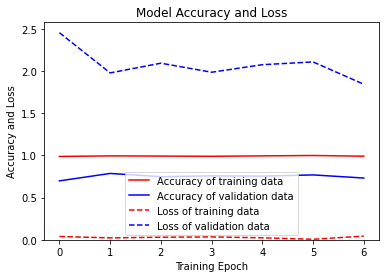

In [ ]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    
show_4_graphs(history)

In [ ]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
p = np.random.rand(6)
p

array([0.07827019, 0.59130926, 0.06565756, 0.45042405, 0.68819647,
       0.41306045])

In [ ]:
np.argmax(p)

4

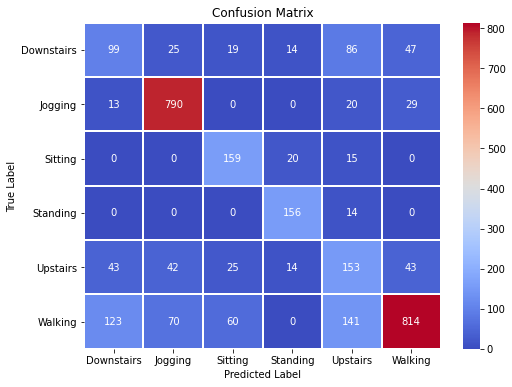

              precision    recall  f1-score   support

           0       0.36      0.34      0.35       290
           1       0.85      0.93      0.89       852
           2       0.60      0.82      0.70       194
           3       0.76      0.92      0.83       170
           4       0.36      0.48      0.41       320
           5       0.87      0.67      0.76      1208

    accuracy                           0.72      3034
   macro avg       0.63      0.69      0.66      3034
weighted avg       0.74      0.72      0.72      3034



In [ ]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# CNN (Conv1D)

In [ ]:
y_test.shape

(3034, 6)

In [ ]:
model_m = Sequential()
model_m.add(Conv1D(16, 2, activation='relu',input_shape=(N,3)))
# model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(32, 2, activation='relu'))
model_m.add(Dropout(0.3))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(32, 2, activation='relu'))
model_m.add(MaxPooling1D(2))
# model_m.add(Conv1D(32, 3, activation='relu'))
# model_m.add(Dropout(0.3))
model_m.add(Flatten())
# model_m.add(Dense(50, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_99 (Conv1D)           (None, 99, 16)            112       
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 98, 32)            1056      
_________________________________________________________________
dropout_37 (Dropout)         (None, 98, 32)            0         
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 48, 32)            2080      
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 768)             

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 5947 samples, validate on 1487 samples
Epoch 1/30
5947/5947 [==============================] - 2s 411us/step - loss: 0.7818 - accuracy: 0.7109 - val_loss: 0.7424 - val_accuracy: 0.7505
Epoch 2/30
5947/5947 [==============================] - 2s 340us/step - loss: 0.3655 - accuracy: 0.8633 - val_loss: 0.8448 - val_accuracy: 0.7888
Epoch 3/30
5947/5947 [==============================] - 2s 339us/step - loss: 0.2736 - accuracy: 0.8912 - val_loss: 0.9068 - val_accuracy: 0.7835
Epoch 4/30
5947/5947 [==============================] - 2s 342us/step - loss: 0.2349 - accuracy: 0.9092 - val_loss: 0.8830 - val_accuracy: 0.7868
Epoch 5/30
5947/5947 [==============================] - 2s 355us/step - loss: 0.1889 - accuracy: 0.9272 - val_loss: 1.0102 - val_accuracy: 0.7996
Epoch 6/30
5947/5947 [==============================] - 2s 341us/step - loss: 0.1757 - accuracy: 0.9332 - val_loss: 1.0966 - val_accuracy: 0.7902
Epoch 7/30
5947/5947 [==============================] - 2s 348us/step - loss

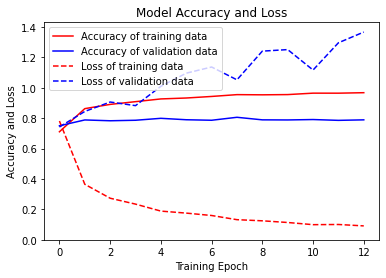

In [ ]:
show_4_graphs(history)

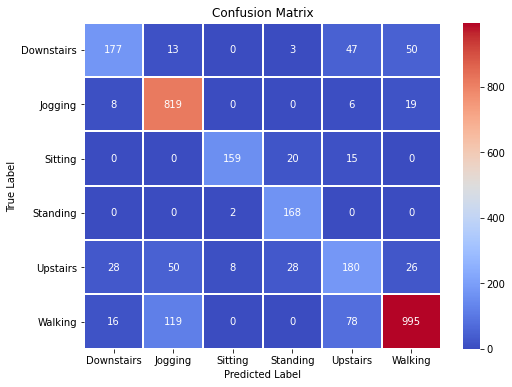

              precision    recall  f1-score   support

           0       0.77      0.61      0.68       290
           1       0.82      0.96      0.88       852
           2       0.94      0.82      0.88       194
           3       0.77      0.99      0.86       170
           4       0.55      0.56      0.56       320
           5       0.91      0.82      0.87      1208

    accuracy                           0.82      3034
   macro avg       0.79      0.79      0.79      3034
weighted avg       0.83      0.82      0.82      3034



In [ ]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# RNN

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

In [ ]:
history = model.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

In [ ]:
show_4_graphs(history)

In [ ]:
y_pred = model.predict(X_test)
show_results(y_test, y_pred)